In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import ROOT


In [2]:
file_path="/Users/snip/Documents/MEOP/Diameter runs for fitting/1_6875_trial.xlsx"
df= pd.read_excel(file_path)
name=file_path.split("/")
name[-1]=name[-1].replace("_trial.xlsx","")

diameter=float(name[-1].replace("_","."))
print(diameter)
df.drop(columns=["Time - Voltage (Formula Result)","Polarization (%) - Voltage (Formula Result)"], inplace=True)
df.rename(columns={"Time - Voltage (Formula Result).1":"time","Polarization (%) - Voltage (Formula Result).1":"polarization"}, inplace=True)


1.6875


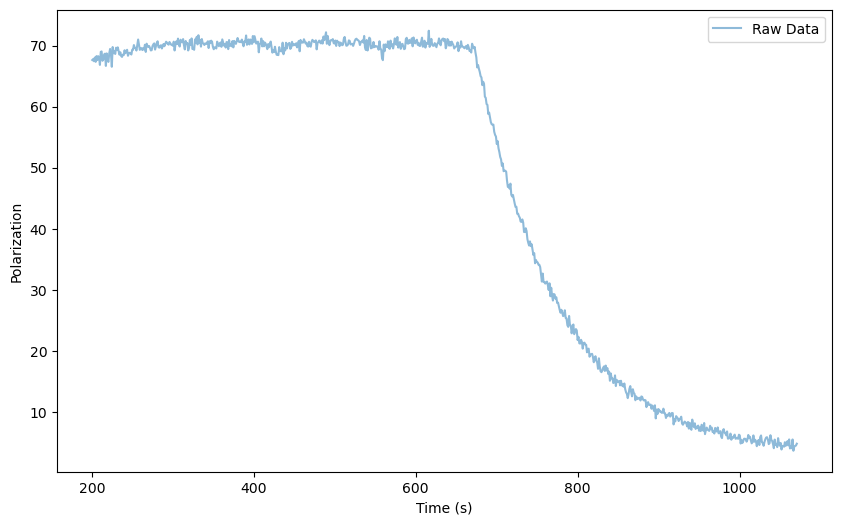

In [3]:
# Convert time string to seconds
# Handle both "MM:SS" and "HH:MM:SS" formats
def time_to_seconds(time_str):
    parts = str(time_str).split(':')
    if len(parts) == 2:  # MM:SS format
        return int(parts[0]) * 60 + float(parts[1])
    elif len(parts) == 3:  # HH:MM:SS format
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
    else:
        return float(time_str)  # Already in seconds
    

df["time"] = df["time"].apply(time_to_seconds)
#rescale time to start from zero
df["time"] = df["time"] - df["time"].min()
df=df[df["time"]>200].reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.show()


In [4]:


df["smoothed"] = savgol_filter(df["polarization"], 30, 3)

#where the decay/fall starts by detecting negative derivative
df["derivative"] = np.gradient(df["smoothed"])

# global max
global_max_index = df["smoothed"].idxmax()

# Look for where decay consistently starts (derivative becomes negative after max)
# AND polarization has decreased by at least 10% from the global max
decay_start_index = global_max_index
global_max_pol = df["smoothed"][global_max_index]
threshold_10_percent = global_max_pol * 0.9  # 10% decrement threshold

for i in range(global_max_index, len(df)):
    # Check if derivative stays negative for next few points (confirms decay started)
    # AND polarization has dropped by at least 10%
    if i + 5 < len(df):
        if all(df["derivative"].iloc[i:i+5] < 0) and df["smoothed"].iloc[i] <= threshold_10_percent:
            decay_start_index = i
            break

# Find the actual maximum just before decay starts
max_index=decay_start_index-12
# max_index = df.loc[:decay_start_index, "smoothed"].idxmax()
max_pol = df["smoothed"][max_index]
min_index = df["smoothed"].idxmin()
min_pol = df["smoothed"][min_index]
print(f"Max index: {max_index}, Min index: {min_index}")
target_value = max_pol / np.e 
print(f"Target value for relaxation: {target_value:.2f}%")
relaxation_data = df.iloc[max_index:min_index+1]
relaxation_data_full = relaxation_data.copy()

# Filter for points above target value
relaxation_data = relaxation_data[relaxation_data["smoothed"] > target_value]
relaxation_data_full = relaxation_data_full[relaxation_data_full["smoothed"] > min_pol]
max_time = df["time"][max_index]

# Check if we have valid relaxation data after filtering
if len(relaxation_data) == 0:
    print(f"⚠ Warning: No data points above target value (1/e point)")
    print(f"Using full decay range for analysis")
    relaxation_data = relaxation_data_full
    if len(relaxation_data) < 2:
        print(f"Error: Insufficient data points for relaxation analysis")
        relaxation_time = 0
    else:
        relaxation_time = relaxation_data["time"].iloc[-1] - max_time
else:
    relaxation_time = relaxation_data["time"].iloc[-1] - max_time

print(f"Global max index: {global_max_index}, Decay start index: {decay_start_index}, Selected max index: {max_index}")
print(f"Max polarization (before decay): {max_pol:.2f}%")
print(f"Relaxation time: {relaxation_time:.3f} seconds")


Max index: 447, Min index: 829
Target value for relaxation: 25.45%
Global max index: 278, Decay start index: 459, Selected max index: 447
Max polarization (before decay): 69.17%
Relaxation time: 114.552 seconds


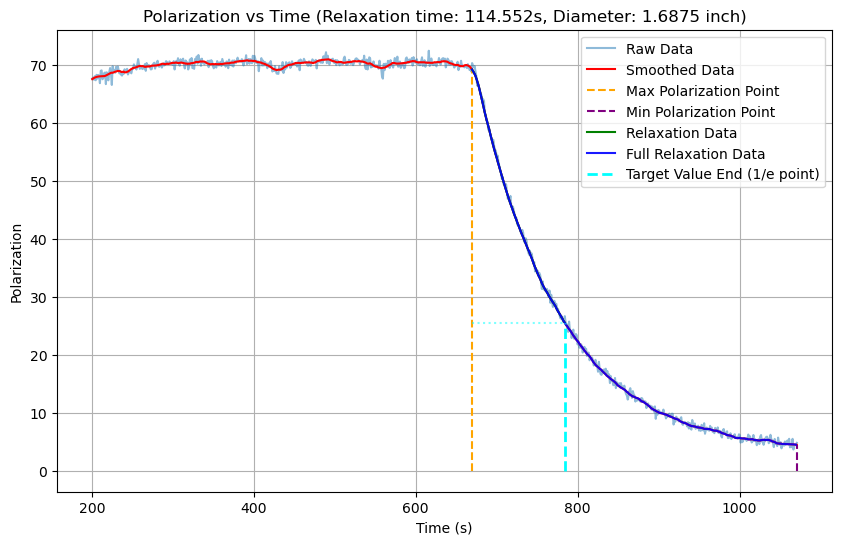

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.vlines(df["time"][max_index], ymin=0, ymax=max_pol, colors='orange', linestyles='--', label='Max Polarization Point')
plt.vlines(df["time"][min_index], ymin=0, ymax=min_pol, colors='purple', linestyles='--', label='Min Polarization Point')
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.plot(relaxation_data["time"], relaxation_data["smoothed"], label="Relaxation Data", color='green')
plt.plot(relaxation_data_full["time"], relaxation_data_full["smoothed"], label="Full Relaxation Data", color='blue', alpha=0.9)
# Add vertical line where target value ends (relaxation time point)
target_end_time = relaxation_data["time"].iloc[-1]
plt.vlines(target_end_time, ymin=0, ymax=target_value, colors='cyan', linestyles='--', label='Target Value End (1/e point)', linewidth=2)
plt.hlines(target_value, xmin=df["time"][max_index], xmax=target_end_time, colors='cyan', linestyles=':', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Polarization")      
plt.title(f"Polarization vs Time (Relaxation time: {np.round(relaxation_time, 3)}s, Diameter: {diameter} inch)")
plt.legend()
plt.grid()
# plt.show()
diameter=str(diameter).replace(".","_")
plt.savefig(f"/Users/snip/Documents/MEOP/relaxation_plots/relaxation_time_plot_{diameter}.png", dpi=300)

In [7]:
relaxation_data_full["time"]

447     669.690
448     670.730
449     671.782
450     672.836
451     673.903
         ...   
824    1065.537
825    1066.586
826    1067.635
827    1068.682
828    1069.731
Name: time, Length: 382, dtype: float64

In [15]:

from array import array

time_data = relaxation_data_full["time"].values
pol_data = relaxation_data_full["smoothed"].values

# Downsample data to reduce overfitting (use every Nth point)
downsample_factor = 5 # Use every 10th point (adjust if needed)
time_data = time_data[::downsample_factor]
pol_data = pol_data[::downsample_factor]
print(f"Downsampled data by factor of {downsample_factor}")
print(f"Number of points after downsampling: {len(time_data)}")

fit_range_min = 674  # Minimum time for fit (seconds)
fit_range_max = 1050  # Maximum time for fit (seconds)

# Initial parameter guesses (will be set after data is loaded)
# P0_init will be calculated as (first_point - baseline)
# tau_init will use the calculated relaxation time
# c_init will be the last point value

# Apply fit range if specified
if fit_range_min is not None or fit_range_max is not None:
    range_min = fit_range_min if fit_range_min is not None else time_data.min()
    range_max = fit_range_max if fit_range_max is not None else time_data.max()
    mask = (time_data >= range_min) & (time_data <= range_max)
    time_data = time_data[mask]
    pol_data = pol_data[mask]
    print(f"Fitting in range: [{range_min}, {range_max}] seconds")
    print(f"Number of points in fit range: {len(time_data)}")
else:
    range_min = time_data.min()
    range_max = time_data.max()
    print(f"Fitting full data range: [{range_min:.1f}, {range_max:.1f}] seconds")

n_points = len(time_data)

# Shift time to start from zero for the fit (important for exponential!)
time_shifted = time_data - time_data.min()
x_arr = array('d', time_shifted.tolist())
y_arr = array('d', pol_data.tolist())

print(f"Time range for fit: {time_data.min():.1f} to {time_data.max():.1f} seconds")
print(f"Shifted time range: 0 to {time_shifted.max():.1f} seconds (for fit)")

# Create TGraph with shifted time
graph = ROOT.TGraph(n_points, x_arr, y_arr)
graph.SetTitle("Relaxation Fit;Time (s);Polarization (%)")
graph.SetMarkerStyle(20)
graph.SetMarkerSize(0.8)
graph.SetMarkerColor(ROOT.kBlue)

#fit function: P0*exp(-t/tau) + c
# parameters: [0]=P0, [1]=tau, [2]=c
# Using shifted time starting from 0
fit_func = ROOT.TF1("fit_func", "[0]*exp(-x/[1]) + [2]", 0, time_shifted.max())
# Set initial parameter estimates
P0_init = 68  # Initial amplitude (difference between start and end)
tau_init = relaxation_time  # Use calculated relaxation time as initial guess
c_init = pol_data[-1]  # Baseline offset

print(f"\nInitial parameter guesses:")
print(f"  P0_init  = {P0_init:.2f} % (amplitude)")
print(f"  tau_init = {tau_init:.2f} s (relaxation time)")
print(f"  c_init   = {c_init:.2f} % (baseline)\n")

fit_func.SetParameter(0, P0_init)
fit_func.SetParameter(1, tau_init)
fit_func.SetParameter(2, c_init)

# Set parameter limits to prevent overfitting
fit_func.SetParLimits(0, 0, 100)  # P0 must be positive and reasonable
fit_func.SetParLimits(1, 20, 200)  # tau between 20s and 200s
fit_func.SetParLimits(2, -50, 100)  # baseline constraint

# Set parameter names
fit_func.SetParName(0, "P0")
fit_func.SetParName(1, "tau")
fit_func.SetParName(2, "c")

# Perform the fit with improved options
# "R" = use function range, "S" = return fit result, "Q" = quiet mode
# "W" = ignore errors in points (for better chi2), "E" = use Minos errors
fit_result = graph.Fit(fit_func, "RS")  # "RS" for basic fit with result

# Extract fit parameters
P0_fit = fit_func.GetParameter(0)
tau_fit = fit_func.GetParameter(1)
c_fit = fit_func.GetParameter(2)

P0_err = fit_func.GetParError(0)
tau_err = fit_func.GetParError(1)
c_err = fit_func.GetParError(2)

# Get correlation matrix
corr_matrix = fit_result.GetCorrelationMatrix()
n_params = 3

# Print results
print("=" * 60)
print("ROOT Fit Results: P0*exp(-t/tau) + c")
print("=" * 60)
print(f"P0  = {P0_fit:.3f} ± {P0_err:.3f} %")
print(f"tau = {tau_fit:.3f} ± {tau_err:.3f} s  (relaxation time)")
print(f"c   = {c_fit:.3f} ± {c_err:.3f} %  (baseline)")
print(f"\nChi2/NDF = {fit_result.Chi2():.2f} / {fit_result.Ndf()}")
chi2_ndf = fit_result.Chi2() / fit_result.Ndf() if fit_result.Ndf() > 0 else 0
print(f"Chi2/NDF ratio = {chi2_ndf:.3f}")

# Quality check
if chi2_ndf < 0.1:
    print(" WARNING: Chi2/NDF < 0.1 suggests possible overfitting!")
    print("   Consider: reducing data points, using simpler function, or checking for systematic errors")
elif chi2_ndf > 10:
    print("WARNING: Chi2/NDF > 10 suggests poor fit quality!")
    print("   Consider: different fit function or checking data quality")

# Print correlation matrix
print("\nParameter Correlation Matrix:")
print("=" * 60)
print(f"{'':>8} {'P0':>12} {'tau':>12} {'c':>12}")
print("-" * 60)
for i in range(n_params):
    param_names = ['P0', 'tau', 'c']
    row = f"{param_names[i]:>8}"
    for j in range(n_params):
        corr_val = corr_matrix[i][j]
        row += f"{corr_val:>12.4f}"
    print(row)
print("=" * 60)
print("Correlation interpretation:")
print("  |ρ| < 0.3  : weak correlation")
print("  0.3 ≤ |ρ| < 0.7 : moderate correlation")
print("  |ρ| ≥ 0.7  : strong correlation (may indicate overfitting)")
print("=" * 60)

# Check for high correlations
high_corr = []
for i in range(n_params):
    for j in range(i+1, n_params):
        corr_val = abs(corr_matrix[i][j])
        if corr_val > 0.7:
            param_names = ['P0', 'tau', 'c']
            high_corr.append(f"{param_names[i]}-{param_names[j]}: {corr_matrix[i][j]:.3f}")

if high_corr:
    print("\n⚠ HIGH CORRELATIONS DETECTED:")
    for corr_str in high_corr:
        print(f"  • {corr_str}")
    print("\nSuggestions to reduce correlation:")
    print("  1. Fix one parameter (e.g., fix baseline 'c' if known)")
    print("  2. Use a narrower fit range")
    print("  3. Increase downsample_factor further")
    print("  4. Consider if baseline is truly needed (try P0*exp(-t/tau) only)")
print("=" * 60)

# Create canvas and plot
c = ROOT.TCanvas("c_fit", "Exponential Decay Fit", 1000, 700)
c.SetGrid()

graph.Draw("AP")
graph.GetXaxis().SetTitle("Time since decay start (s)")
graph.GetYaxis().SetTitle("Polarization (%)")
fit_func.SetLineColor(ROOT.kRed)
fit_func.SetLineWidth(2)
fit_func.SetRange(0, time_shifted.max())  # Limit fit line to fit range only
fit_func.Draw("SAME")

# Add legend with fit parameters
legend = ROOT.TLegend(0.6, 0.65, 0.88, 0.88)
legend.SetTextSize(0.03)
legend.AddEntry(graph, "Data", "p")
legend.AddEntry(fit_func, "Fit: P_{0}e^{-t/#tau} + c", "l")
legend.AddEntry(0, f"P_{0} = {P0_fit:.2f} #pm {P0_err:.2f}", "")
legend.AddEntry(0, f"#tau = {tau_fit:.2f} #pm {tau_err:.2f} s", "")
legend.AddEntry(0, f"c = {c_fit:.2f} #pm {c_err:.2f}", "")
legend.AddEntry(0, f"#chi^{2}/NDF = {fit_result.Chi2():.1f}/{fit_result.Ndf()}", "")
legend.Draw()

c.Draw()
c.Update()

# Save plot
diameter_str = str(diameter).replace(".", "_")
output_path = f"/Users/snip/Documents/MEOP/relaxation_plots/root_fit_{diameter_str}.png"
c.SaveAs(output_path)
print(f"\n✓ Plot saved to: {output_path}")

Downsampled data by factor of 5
Number of points after downsampling: 77
Fitting in range: [674, 1050] seconds
Number of points in fit range: 72
Time range for fit: 674.9 to 1047.7 seconds
Shifted time range: 0 to 372.7 seconds (for fit)

Initial parameter guesses:
  P0_init  = 68.00 % (amplitude)
  tau_init = 114.55 s (relaxation time)
  c_init   = 4.69 % (baseline)

ROOT Fit Results: P0*exp(-t/tau) + c
P0  = 65.006 ± 0.063 %
tau = 102.623 ± 0.273 s  (relaxation time)
c   = 3.031 ± 0.046 %  (baseline)

Chi2/NDF = 1.37 / 69
Chi2/NDF ratio = 0.020
   Consider: reducing data points, using simpler function, or checking for systematic errors

Parameter Correlation Matrix:
                   P0          tau            c
------------------------------------------------------------
      P0      1.0000     -0.1032     -0.2808
     tau     -0.1032      1.0000     -0.8563
       c     -0.2808     -0.8563      1.0000
Correlation interpretation:
  |ρ| < 0.3  : weak correlation
  0.3 ≤ |ρ| < 0.7 : 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_fit
Info in <TCanvas::Print>: png file /Users/snip/Documents/MEOP/relaxation_plots/root_fit_1_6875.png has been created


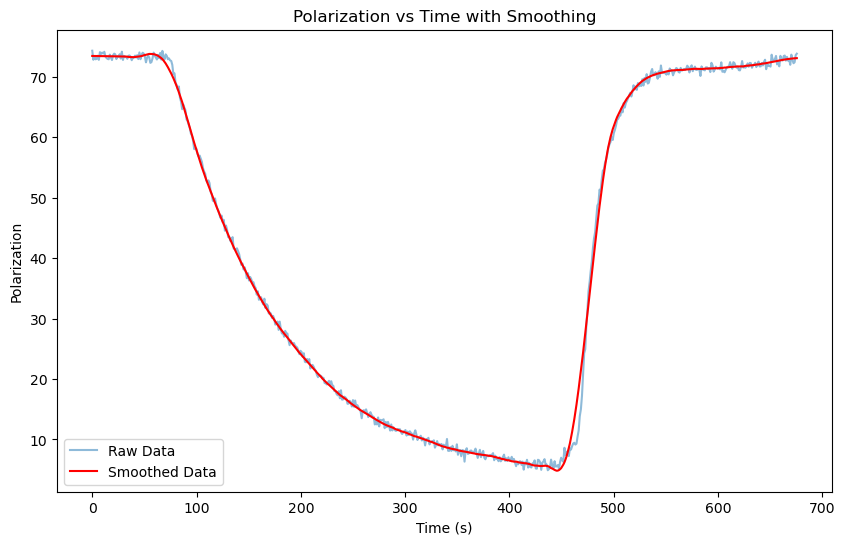

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.show()

In [ ]:
import os
from pathlib import Path

# Directory containing all the Excel files
data_dir = "/Users/snip/Documents/MEOP/Diameter runs for fitting"
output_dir = "/Users/snip/Documents/MEOP/relaxation_plots"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all Excel files in the directory
excel_files = list(Path(data_dir).glob("*.xlsx"))
print(f"Found {len(excel_files)} Excel files to process\n")

# Process each file
results = []
for file_path in excel_files:
    try:
        print(f"Processing: {file_path.name}")
        
        # Read the data
        df = pd.read_excel(str(file_path))
        
        # Extract diameter from filename
        name_parts = file_path.stem.split("_")
        diameter = float(file_path.stem.replace("_trial", "").replace("_", "."))
        
        # Drop and rename columns
        df.drop(columns=["Time - Voltage (Formula Result)", "Polarization (%) - Voltage (Formula Result)"], inplace=True)
        df.rename(columns={"Time - Voltage (Formula Result).1": "time", 
                          "Polarization (%) - Voltage (Formula Result).1": "polarization"}, inplace=True)
        
        # Convert time to seconds
        def time_to_seconds(time_str):
            parts = str(time_str).split(':')
            if len(parts) == 2:
                return int(parts[0]) * 60 + float(parts[1])
            elif len(parts) == 3:
                return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
            else:
                return float(time_str)
        
        df["time"] = df["time"].apply(time_to_seconds)
        df["time"] = df["time"] - df["time"].min()  # Start from zero
        
        # Apply smoothing
        df["smoothed"] = savgol_filter(df["polarization"], 60, 3)
        df["derivative"] = np.gradient(df["smoothed"])
        
        # Find max and decay start
        global_max_index = df["smoothed"].idxmax()
        decay_start_index = global_max_index
        global_max_pol = df["smoothed"][global_max_index]
        threshold_10_percent = global_max_pol * 0.9  # 10% decrement threshold
        
        for i in range(global_max_index, len(df)):
            if i + 5 < len(df):
                if all(df["derivative"].iloc[i:i+5] < 0) and df["smoothed"].iloc[i] <= threshold_10_percent:
                    decay_start_index = i
                    break
        
        max_index = df.loc[:decay_start_index, "smoothed"].idxmax()
        max_pol = df["smoothed"][max_index]
        min_index = df["smoothed"].idxmin()
        min_pol = df["smoothed"][min_index]
        
        # Calculate relaxation time
        target_value = max_pol / np.e
        relaxation_data = df.iloc[max_index:min_index+1]
        relaxation_data = relaxation_data[relaxation_data["smoothed"] > target_value]
        max_time = df["time"][max_index]
        
        # Check if we have valid relaxation data
        if len(relaxation_data) == 0:
            print(f"  ⚠ Warning: No data points above target value (1/e point)")
            print(f"  Using full decay range for analysis")
            relaxation_data = df.iloc[max_index:min_index+1]
            if len(relaxation_data) < 2:
                raise ValueError("Insufficient data points for relaxation analysis")
        
        relaxation_time = relaxation_data["time"].iloc[-1] - max_time
        
        # Store results
        results.append({
            "filename": file_path.name,
            "diameter": diameter,
            "relaxation_time": relaxation_time,
            "max_pol": max_pol
        })
        
        # Create and save plot
        plt.figure(figsize=(12, 7))
        plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
        plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red', linewidth=2)
        
        # Only plot relaxation data if we have valid points above target
        if len(relaxation_data[relaxation_data["smoothed"] > target_value]) > 0:
            plt.plot(relaxation_data["time"], relaxation_data["smoothed"], label="Relaxation Data", color='green', linewidth=2)
        
        # Add vertical lines
        plt.vlines(df["time"][max_index], ymin=0, ymax=max_pol, colors='orange', linestyles='--', 
                  label='Max Polarization Point', linewidth=2)
        target_end_time = relaxation_data["time"].iloc[-1]
        plt.vlines(target_end_time, ymin=0, ymax=target_value, colors='cyan', linestyles='--', 
                  label='Target Value End (1/e point)', linewidth=2)
        plt.hlines(target_value, xmin=df["time"][max_index], xmax=target_end_time, 
                  colors='cyan', linestyles=':', alpha=0.5)
        
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Polarization (%)", fontsize=12)
        plt.title(f"Relaxation Time Analysis\nDiameter: {diameter} inch | τ = {relaxation_time:.3f}s", fontsize=14)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        
        # Save with original filename
        output_filename = file_path.stem + "_relaxation.png"
        output_path = os.path.join(output_dir, output_filename)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ Diameter: {diameter} inch | Relaxation time: {relaxation_time:.3f}s")
        print(f"  ✓ Saved: {output_filename}\n")
        
    except Exception as e:
        print(f"  ✗ Error processing {file_path.name}: {str(e)}\n")

# Summary
print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"Processed {len(results)} files successfully")
print(f"Plots saved to: {output_dir}")
print(f"{'='*60}\n")

# Display summary table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('diameter')
print("\nSummary of Results:")
print(results_df.to_string(index=False))
results_df

Found 4 Excel files to process

Processing: 1_6875_trial.xlsx
  ⚠ Warning: No data points above target value (1/e point)
  Using full decay range for analysis
  ✗ Error processing 1_6875_trial.xlsx: Insufficient data points for relaxation analysis

Processing: 1_625_adjusted.xlsx
  ✗ Error processing 1_625_adjusted.xlsx: could not convert string to float: '1.625.adjusted'

Processing: 1_5625_trial.xlsx
  ✓ Diameter: 1.5625 inch | Relaxation time: 129.314s
  ✓ Saved: 1_5625_trial_relaxation.png

Processing: 1_625_trial.xlsx
  ⚠ Warning: No data points above target value (1/e point)
  Using full decay range for analysis
  ✗ Error processing 1_625_trial.xlsx: Insufficient data points for relaxation analysis


Processing complete!
Processed 1 files successfully
Plots saved to: /Users/snip/Documents/MEOP/relaxation_plots


Summary of Results:
         filename  diameter  relaxation_time   max_pol
1_5625_trial.xlsx    1.5625          129.314 73.773612


,filename,diameter,relaxation_time,max_pol
0,1_5625_trial.xlsx,1.5625,129.314,73.773612
